In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image, ExifTags, UnidentifiedImageError
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
root_folder = "./images"
labels = []
file_paths = []
i = 0
# Traverse through the root folder
for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    # Check if it's a directory
    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)
            
            # Check if the file is an image and can be opened
            try:
                with Image.open(file_path) as img:
                    # If the image can be opened, add it to the lists
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError):
                # If the image cannot be opened, remove the file
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)
    i += 1
# Create a DataFrame
df = pd.DataFrame({"label": labels, "path": file_paths})

# Display the DataFrame
print(df)

                   label                                      path
0                 Acacia              ./images\Acacia\IMG_6348.JPG
1                 Acacia              ./images\Acacia\IMG_6349.JPG
2                 Acacia              ./images\Acacia\IMG_6350.JPG
3                 Acacia              ./images\Acacia\IMG_6351.JPG
4                 Acacia              ./images\Acacia\IMG_6352.JPG
...                  ...                                       ...
5573  Wrightia religiosa  ./images\Wrightia religiosa\IMG_2372.JPG
5574  Wrightia religiosa  ./images\Wrightia religiosa\IMG_2373.JPG
5575  Wrightia religiosa  ./images\Wrightia religiosa\IMG_2374.JPG
5576  Wrightia religiosa  ./images\Wrightia religiosa\IMG_2375.JPG
5577  Wrightia religiosa  ./images\Wrightia religiosa\IMG_2376.JPG

[5578 rows x 2 columns]


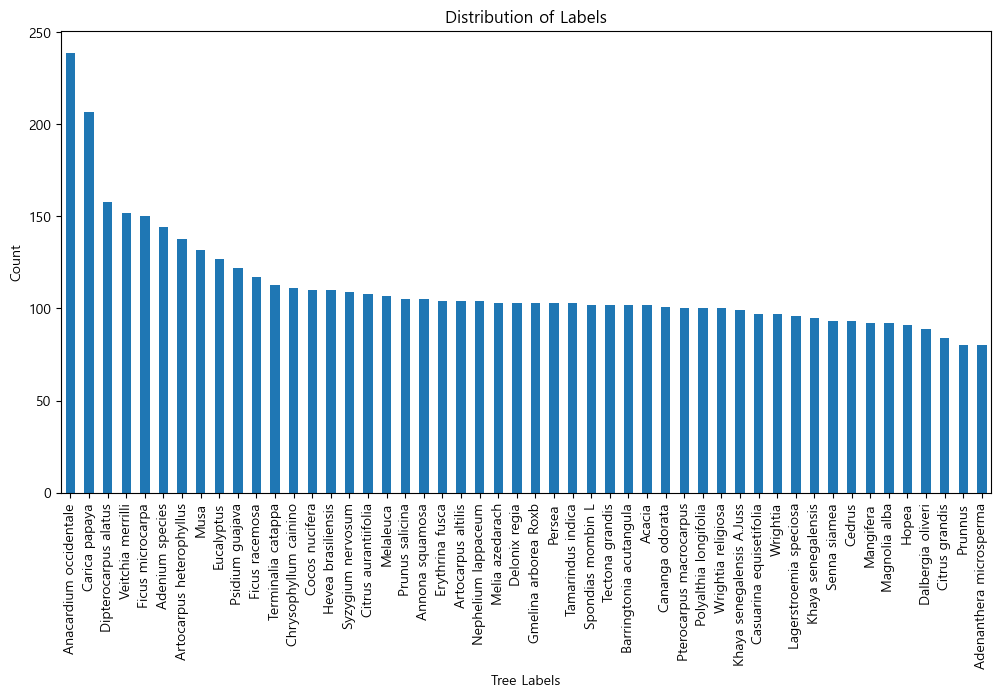

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Assuming your DataFrame is named df

# Count the occurrences of each label
label_counts = df['label'].value_counts()
# Plot the distribution
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [5]:
print(df['label'].unique())
print(len(df['label'].unique()))

['Acacia' 'Adenanthera microsperma' 'Adenium species'
 'Anacardium occidentale' 'Annona squamosa' 'Artocarpus altilis'
 'Artocarpus heterophyllus' 'Barringtonia acutangula' 'Cananga odorata'
 'Carica papaya' 'Casuarina equisetifolia' 'Cedrus'
 'Chrysophyllum cainino' 'Citrus aurantiifolia' 'Citrus grandis'
 'Cocos nucifera' 'Dalbergia oliveri' 'Delonix regia'
 'Dipterocarpus alatus' 'Erythrina fusca' 'Eucalyptus' 'Ficus microcarpa'
 'Ficus racemosa' 'Gmelina arborea Roxb' 'Hevea brasiliensis' 'Hopea'
 'Khaya senegalensis' 'Khaya senegalensis A.Juss' 'Lagerstroemia speciosa'
 'Magnolia alba' 'Mangifera' 'Melaleuca' 'Melia azedarach' 'Musa'
 'Nephelium lappaceum' 'Persea' 'Polyalthia longifolia' 'Prunnus'
 'Prunus salicina' 'Psidium guajava' 'Pterocarpus macrocarpus'
 'Senna siamea' 'Spondias mombin L' 'Syzygium nervosum'
 'Tamarindus indica' 'Tectona grandis' 'Terminalia catappa'
 'Veitchia merrilli' 'Wrightia' 'Wrightia religiosa']
50


In [6]:
# EXIF 데이터를 통해 이미지 방향을 수정하는 함수
def correct_image_orientation(img):
    try:
        exif = img._getexif()
        if exif is not None:
            for orientation_tag, orientation_value in ExifTags.TAGS.items():
                if orientation_value == 'Orientation':
                    orientation = exif.get(orientation_tag)
                    if orientation == 3:
                        img = img.rotate(180, expand=True)
                    elif orientation == 6:
                        img = img.rotate(270, expand=True)
                    elif orientation == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError, TypeError):
        # EXIF 데이터가 없거나, 태그를 찾을 수 없거나, 이미지 포맷이 EXIF를 지원하지 않는 경우
        pass
    return img

In [7]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [8]:
df

,label,path,label_encoded
0,Acacia,./images\Acacia\IMG_6348.JPG,0
1,Acacia,./images\Acacia\IMG_6349.JPG,0
2,Acacia,./images\Acacia\IMG_6350.JPG,0
3,Acacia,./images\Acacia\IMG_6351.JPG,0
4,Acacia,./images\Acacia\IMG_6352.JPG,0
...,...,...,...
5573,Wrightia religiosa,./images\Wrightia religiosa\IMG_2372.JPG,49
5574,Wrightia religiosa,./images\Wrightia religiosa\IMG_2373.JPG,49
5575,Wrightia religiosa,./images\Wrightia religiosa\IMG_2374.JPG,49
5576,Wrightia religiosa,./images\Wrightia religiosa\IMG_2375.JPG,49


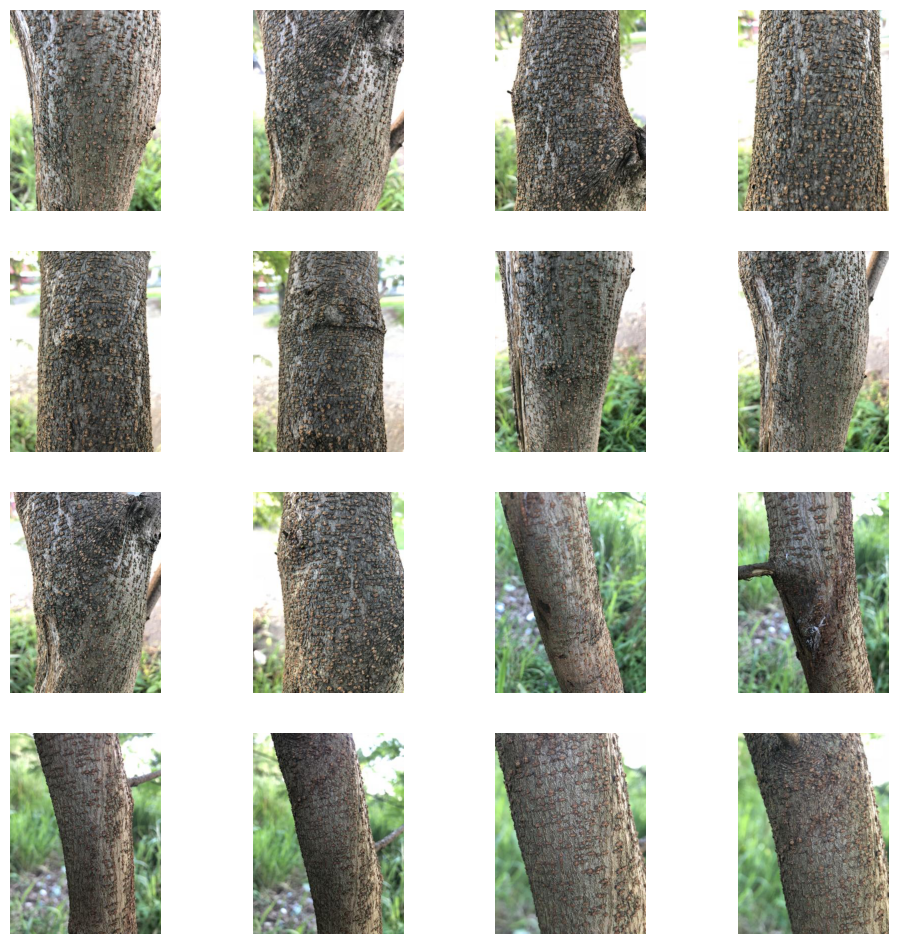

In [9]:
# 이미지 파일 경로들
image_paths = df['path'][:16]

# 이미지를 4x4 격자로 출력
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # 이미지 불러오기
    img_path = image_paths[i]
    img = Image.open(img_path)

    # 이미지 출력
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [10]:
train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

In [11]:
train

,path,label_encoded
1302,./images\Carica papaya\IMG_5376.JPG,9
3170,./images\Khaya senegalensis\IMG_4780.JPG,26
2986,./images\Hopea\IMG_6255.JPG,25
833,./images\Artocarpus heterophyllus\IMG_5971.JPG,6
5125,./images\Terminalia catappa\IMG_4591.JPG,46
...,...,...
4112,./images\Polyalthia longifolia\IMG_6462.JPG,36
2064,./images\Delonix regia\IMG_4539.JPG,17
1416,./images\Casuarina equisetifolia\IMG_5480.JPG,10
2043,./images\Delonix regia\IMG_4518.JPG,17


In [12]:
BATCH_SIZE = 16

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)
        
        return image, label


transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

flip_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

bright_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    # transforms.Resize((224, 224)),              
    transforms.ColorJitter(brightness=(0.5, 0.9),),
    transforms.ToTensor()
])

In [13]:
pyramid_folder = './pyramid'
os.makedirs(pyramid_folder, exist_ok=True)  # 폴더가 없으면 생성

In [14]:
def create_image_pyramid(img_path, pyramid_folder, levels=3):
    img = Image.open(img_path)
    pyramid = [img_path]  # 원본 이미지 포함

    for level in range(1, levels):
        img_resized = img.resize((img.width // 2**level, img.height // 2**level), Image.ANTIALIAS)
        
        # 원본 파일명과 확장자 분리
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        
        # 새 파일명 생성
        resized_path = os.path.join(pyramid_folder, f"{name}_pyramid_{level}{ext}")
        img_resized.save(resized_path)
        pyramid.append(resized_path)

    return pyramid


In [15]:
# extended_data = []
# for _, row in df.iterrows():
#     pyramid_paths = create_image_pyramid(row['path'], pyramid_folder)
#     for path in pyramid_paths:
#         extended_data.append({'path': path, 'label_encoded': row['label_encoded']})

# extended_df = pd.DataFrame(extended_data)

In [16]:
# extended_df.to_csv('pyramid_dataframe.csv', index=False)

In [17]:
# CSV 파일을 데이터 프레임으로 읽기
extended_df = pd.read_csv('pyramid_dataframe.csv')

In [18]:
train = extended_df
train

,path,label_encoded
0,./images\Acacia\IMG_6348.JPG,0
1,./pyramid\IMG_6348_pyramid_1.JPG,0
2,./pyramid\IMG_6348_pyramid_2.JPG,0
3,./images\Acacia\IMG_6349.JPG,0
4,./pyramid\IMG_6349_pyramid_1.JPG,0
...,...,...
16729,./pyramid\IMG_2375_pyramid_1.JPG,49
16730,./pyramid\IMG_2375_pyramid_2.JPG,49
16731,./images\Wrightia religiosa\IMG_2376.JPG,49
16732,./pyramid\IMG_2376_pyramid_1.JPG,49


In [19]:
# 원하는 원본 이미지 파일명
original_image_name = 'IMG_3762'

# 해당 원본 이미지의 피라미드 이미지들을 필터링
pyramid_images = train[train['path'].str.contains(original_image_name)]

# 결과 출력
pyramid_images

,path,label_encoded
16374,./images\Wrightia\IMG_3762.JPG,48
16375,./pyramid\IMG_3762_pyramid_1.JPG,48
16376,./pyramid\IMG_3762_pyramid_2.JPG,48


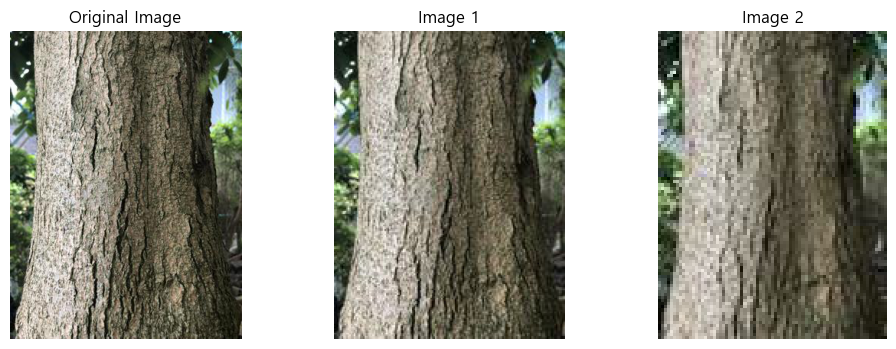

In [20]:
plt.figure(figsize=(16, 4))

for i, img_path in enumerate(pyramid_images['path'], 1):
    img = Image.open(img_path)
    plt.subplot(1, 4, i)
    plt.imshow(img)
    if i == 1:
        plt.title(f"Original Image")
    else:
        plt.title(f"Image {i-1}")
    plt.axis('off')

plt.show()

In [21]:
train_dataset = TreeDataset(dataframe=train, transform=transform)
flip_dataset = TreeDataset(dataframe=train, transform=flip_transform)
bright_dataset = TreeDataset(dataframe=train, transform=bright_transform)
train_dataset = train_dataset + flip_dataset + bright_dataset

test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

50202
837
837


In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

3138
53
53


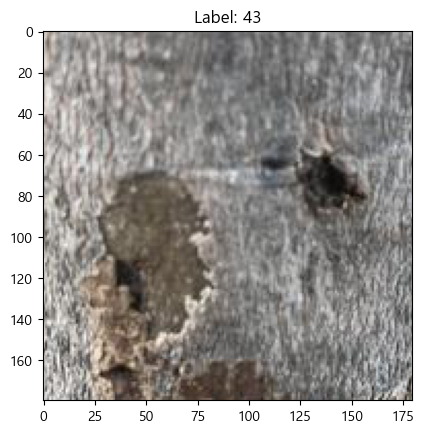

In [23]:
for images, labels in train_loader:
    
    # 이미지를 시각화하기 위해 배치에서 이미지 하나를 선택
    img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # 채널 순서 변경 및 NumPy 배열로 변환
    # print(img)
    # print(img.shape)
    
    # 이미지 시각화
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()
    
    break  # 첫 번째 배치만 시각화

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
num_classes = len(df['label_encoded'].unique())
model = models.convnext_small(pretrained=True).to(device)

# 파라미터 고정
for param in model.parameters():
    param.requires_grad = False

# 마지막 분류기 레이어 교체
model.classifier[2] = nn.Linear(768, num_classes).to(device)

c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# model = models.resnet50(pretrained=True).to(device)
# num_classes = len(df['label_encoded'].unique())

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.ReLU(inplace = True),
#     nn.Linear(128, num_classes)).to(device)



In [27]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 40
best_val_accuracy = 0.0  # 최고의 검증 정확도를 저장하기 위한 변수

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(valid_loader)
        print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')

        # 최고의 검증 정확도일 때 모델 저장
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), 'barkVN-noresize.pth')
            print('Best model saved.')

# 전체 학습이 끝난 후 최고의 모델을 저장했습니다.

Epoch 1/40:   0%|          | 0/3138 [00:00<?, ?it/s]

Epoch 1/40: 100%|██████████| 3138/3138 [51:53<00:00,  1.01it/s]


Training Loss: 1.1189133825529678
Validation Loss: 0.4080471981246516, Validation Accuracy: 89.96%
Best model saved.


Epoch 2/40: 100%|██████████| 3138/3138 [50:33<00:00,  1.03it/s]


Training Loss: 0.7058015480765764
Validation Loss: 0.2786632477534267, Validation Accuracy: 93.79%
Best model saved.


Epoch 3/40: 100%|██████████| 3138/3138 [50:45<00:00,  1.03it/s]


Training Loss: 0.6246186866549035
Validation Loss: 0.2238120217368288, Validation Accuracy: 95.22%
Best model saved.


Epoch 4/40: 100%|██████████| 3138/3138 [51:24<00:00,  1.02it/s]


Training Loss: 0.5927047763242985
Validation Loss: 0.21333884925774807, Validation Accuracy: 95.70%
Best model saved.


Epoch 5/40: 100%|██████████| 3138/3138 [51:42<00:00,  1.01it/s]


Training Loss: 0.5642695983182081
Validation Loss: 0.17861053888809006, Validation Accuracy: 96.54%
Best model saved.


Epoch 6/40: 100%|██████████| 3138/3138 [50:39<00:00,  1.03it/s]


Training Loss: 0.5431457295232685
Validation Loss: 0.19977013837054092, Validation Accuracy: 94.38%


Epoch 7/40: 100%|██████████| 3138/3138 [49:29<00:00,  1.06it/s] 


Training Loss: 0.530305218127235
Validation Loss: 0.15620561086414558, Validation Accuracy: 95.70%


Epoch 8/40: 100%|██████████| 3138/3138 [49:43<00:00,  1.05it/s] 


Training Loss: 0.517917056021876
Validation Loss: 0.14914946760630832, Validation Accuracy: 97.13%
Best model saved.


Epoch 9/40: 100%|██████████| 3138/3138 [51:51<00:00,  1.01it/s]


Training Loss: 0.5096059333855955
Validation Loss: 0.14243753293072278, Validation Accuracy: 96.54%


Epoch 10/40: 100%|██████████| 3138/3138 [52:08<00:00,  1.00it/s] 


Training Loss: 0.5044296240722529
Validation Loss: 0.1305853460546372, Validation Accuracy: 96.54%


Epoch 11/40: 100%|██████████| 3138/3138 [49:19<00:00,  1.06it/s]


Training Loss: 0.4999312286094838
Validation Loss: 0.10759897382473047, Validation Accuracy: 97.73%
Best model saved.


Epoch 12/40: 100%|██████████| 3138/3138 [49:50<00:00,  1.05it/s]


Training Loss: 0.4951089874184183
Validation Loss: 0.1249675434434189, Validation Accuracy: 96.42%


Epoch 13/40: 100%|██████████| 3138/3138 [49:12<00:00,  1.06it/s] 


Training Loss: 0.49076519661670265
Validation Loss: 0.11973742123271497, Validation Accuracy: 97.25%


Epoch 14/40: 100%|██████████| 3138/3138 [48:45<00:00,  1.07it/s] 


Training Loss: 0.4828223048093793
Validation Loss: 0.1154952695470233, Validation Accuracy: 97.61%


Epoch 15/40: 100%|██████████| 3138/3138 [49:16<00:00,  1.06it/s] 


Training Loss: 0.47947992030899184
Validation Loss: 0.12307760569284547, Validation Accuracy: 96.54%


Epoch 16/40: 100%|██████████| 3138/3138 [48:50<00:00,  1.07it/s] 


Training Loss: 0.47826896912024763
Validation Loss: 0.1100911751459792, Validation Accuracy: 96.89%


Epoch 17/40: 100%|██████████| 3138/3138 [48:43<00:00,  1.07it/s] 


Training Loss: 0.4708578558039179
Validation Loss: 0.10943018430668228, Validation Accuracy: 97.01%


Epoch 18/40: 100%|██████████| 3138/3138 [48:29<00:00,  1.08it/s] 


Training Loss: 0.4757515261088628
Validation Loss: 0.10856383617194194, Validation Accuracy: 97.73%


Epoch 19/40: 100%|██████████| 3138/3138 [49:07<00:00,  1.06it/s] 


Training Loss: 0.4757033655980283
Validation Loss: 0.10994223324265683, Validation Accuracy: 97.13%


Epoch 20/40: 100%|██████████| 3138/3138 [49:07<00:00,  1.06it/s] 


Training Loss: 0.47176410956100495
Validation Loss: 0.09500445787496162, Validation Accuracy: 98.33%
Best model saved.


Epoch 21/40: 100%|██████████| 3138/3138 [49:11<00:00,  1.06it/s] 


Training Loss: 0.4661053821088068
Validation Loss: 0.081398442405153, Validation Accuracy: 98.09%


Epoch 22/40: 100%|██████████| 3138/3138 [48:55<00:00,  1.07it/s] 


Training Loss: 0.4656440826563831
Validation Loss: 0.08724540553741017, Validation Accuracy: 97.85%


Epoch 23/40: 100%|██████████| 3138/3138 [49:09<00:00,  1.06it/s] 


Training Loss: 0.45876247391883473
Validation Loss: 0.09391884962623974, Validation Accuracy: 97.61%


Epoch 24/40: 100%|██████████| 3138/3138 [49:14<00:00,  1.06it/s] 


Training Loss: 0.45917672981016
Validation Loss: 0.08899058584774018, Validation Accuracy: 97.61%


Epoch 25/40: 100%|██████████| 3138/3138 [48:49<00:00,  1.07it/s] 


Training Loss: 0.45730816955012465
Validation Loss: 0.08048443745751425, Validation Accuracy: 98.21%


Epoch 26/40: 100%|██████████| 3138/3138 [49:03<00:00,  1.07it/s] 


Training Loss: 0.4570378185934853
Validation Loss: 0.10679894461700658, Validation Accuracy: 96.89%


Epoch 27/40: 100%|██████████| 3138/3138 [48:58<00:00,  1.07it/s] 


Training Loss: 0.45224722084506797
Validation Loss: 0.09220038376361975, Validation Accuracy: 97.85%


Epoch 28/40: 100%|██████████| 3138/3138 [49:38<00:00,  1.05it/s]


Training Loss: 0.4603998730798448
Validation Loss: 0.08248942763597336, Validation Accuracy: 97.85%


Epoch 29/40: 100%|██████████| 3138/3138 [49:36<00:00,  1.05it/s] 


Training Loss: 0.4536871435197867
Validation Loss: 0.07808770409802783, Validation Accuracy: 98.57%
Best model saved.


Epoch 30/40: 100%|██████████| 3138/3138 [49:15<00:00,  1.06it/s]


Training Loss: 0.4526770567976133
Validation Loss: 0.08242241484728062, Validation Accuracy: 98.33%


Epoch 31/40: 100%|██████████| 3138/3138 [50:25<00:00,  1.04it/s]


Training Loss: 0.45114239863947464
Validation Loss: 0.08079300963161688, Validation Accuracy: 98.33%


Epoch 32/40: 100%|██████████| 3138/3138 [51:03<00:00,  1.02it/s]


Training Loss: 0.44971692647838074
Validation Loss: 0.07589020922709748, Validation Accuracy: 98.09%


Epoch 33/40: 100%|██████████| 3138/3138 [50:48<00:00,  1.03it/s]


Training Loss: 0.44601869917595777
Validation Loss: 0.08051181116299529, Validation Accuracy: 98.09%


Epoch 34/40: 100%|██████████| 3138/3138 [55:44<00:00,  1.07s/it] 


Training Loss: 0.44795945746313076
Validation Loss: 0.06943010007259699, Validation Accuracy: 98.57%


Epoch 35/40: 100%|██████████| 3138/3138 [50:29<00:00,  1.04it/s] 


Training Loss: 0.4497042466714798
Validation Loss: 0.07935967705792414, Validation Accuracy: 97.97%


Epoch 36/40: 100%|██████████| 3138/3138 [48:08<00:00,  1.09it/s]


Training Loss: 0.4433858508476839
Validation Loss: 0.0839925545865213, Validation Accuracy: 97.97%


Epoch 37/40: 100%|██████████| 3138/3138 [48:12<00:00,  1.08it/s]


Training Loss: 0.44018462632407024
Validation Loss: 0.07685260838424822, Validation Accuracy: 97.85%


Epoch 38/40: 100%|██████████| 3138/3138 [48:06<00:00,  1.09it/s]


Training Loss: 0.4484454947603906
Validation Loss: 0.08231654214092864, Validation Accuracy: 97.97%


Epoch 39/40: 100%|██████████| 3138/3138 [48:33<00:00,  1.08it/s] 


Training Loss: 0.447476056986711
Validation Loss: 0.06707019421254408, Validation Accuracy: 98.57%


Epoch 40/40: 100%|██████████| 3138/3138 [48:43<00:00,  1.07it/s] 


Training Loss: 0.44832754374566025
Validation Loss: 0.07133509435708511, Validation Accuracy: 98.57%


## Test

In [31]:
model.load_state_dict(torch.load('barkVN-noresize.pth'))
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [32]:
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.57%
